## Task for Haensel AMS
### Description

The target variable is Price. You have 7 attributes and obviously we want you to build some initial ML model which predicts the prices.

1. Make some initial data analysis, which will hint to some stuctures in the data and how attributes are connected.
2. Fit some ML model(s) and explain briefly your choices.
3. Show with some X-validation the power of your model and comment the results.
4. Present us the results and the steps you have taken and also with some critical thinking and next steps.
    - well commented and easy to follow code
    - PDF (max 3 pages) with brief steps taken and results (incl. intermediates)

Please use Python for your solution.

In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## EDA

Let's take a look at the data

In [2]:
!head sample.csv
!tail sample.csv

loc1,loc2,para1,dow,para2,para3,para4,price
0,01,1,Mon,662,3000.0,3.8,73.49
9,99,1,Thu,340,2760.0,9.2,300.0
0,04,0,Mon,16,2700.0,3.0,130.0
4,40,1,Mon,17,12320.0,6.4,365.0
5,50,1,Thu,610,2117.0,10.8,357.5
0,03,1,Tue,483,1899.0,13.6,550.0
0,09,1,Mon,214,1000.0,3.0,210.0
7,74,1,Wed,452,330.0,3.0,366.67
8,89,1,Tue,130,8000.0,4.5,193.33
9,90,1,Wed,595,15000.0,13.6,620.0
3,39,4,Thu,143,24826.0,13.6,190.0
2,20,0,Wed,323,20000.0,13.6,420.0
2,20,0,Thu,291,1000.0,4.0,175.0
6,67,1,Tue,628,957.0,5.2,250.0
9,98,3,Fri,386,5000.0,12.0,460.0
7,74,1,Thu,386,3250.0,8.0,325.0
0,06,0,Tue,190,8856.0,5.6,133.33
7,74,3,Fri,717,5000.0,13.6,820.0
7,75,1,Thu,622,336.0,4.8,375.0


In [3]:
df_all = pd.read_csv('./sample.csv')
df_all.head()

,loc1,loc2,para1,dow,para2,para3,para4,price
0,0,01,1,Mon,662,3000.0,3.8,73.49
1,9,99,1,Thu,340,2760.0,9.2,300.00
2,0,04,0,Mon,16,2700.0,3.0,130.00
3,4,40,1,Mon,17,12320.0,6.4,365.00
4,5,50,1,Thu,610,2117.0,10.8,357.50


Are there missing values?

In [4]:
df_all.isnull().sum()

loc1     0
loc2     0
para1    0
dow      0
para2    0
para3    0
para4    0
price    0
dtype: int64

What are the types of data?

In [5]:
df_all.dtypes

loc1      object
loc2      object
para1      int64
dow       object
para2      int64
para3    float64
para4    float64
price    float64
dtype: object

First, let's have a look at the number of unique values across different variables:

In [6]:
df_all.loc1.value_counts()

2    1607
0    1486
1    1223
7    1081
3     945
5     846
4     773
8     727
9     690
6     620
T       1
S       1
Name: loc1, dtype: int64

In [7]:
df_all.loc2.value_counts()

21    499
06    454
74    329
12    273
14    246
01    241
22    226
50    217
23    215
89    194
09    192
04    180
20    168
15    168
67    167
16    166
31    160
28    149
19    149
39    146
59    142
47    139
08    137
99    133
85    130
13    128
49    127
90    127
76    123
63    119
     ... 
26     43
36     43
46     42
81     40
10     39
05     38
92     37
94     35
96     35
65     34
60     31
17     28
98     25
84     24
18     24
69     15
80     11
61     10
82      9
62      5
11      2
0N      1
0C      1
0B      1
0T      1
0L      1
43      1
S6      1
TS      1
00      1
Name: loc2, dtype: int64

In [8]:
df_all.para1.value_counts()

1      7052
3      1613
0       836
2       268
4       164
5        51
6         6
7         3
13        2
9         2
337       1
24        1
8         1
Name: para1, dtype: int64

It seems that `para1` is also a categorical variable

In [9]:
df_all.para2.nunique()

1016

In [10]:
df_all.para3.nunique()

4359

In [11]:
df_all.para4.nunique()

243

In [12]:
df_all.dow.value_counts()

Wed    2233
Tue    1997
Fri    1931
Mon    1918
Thu    1908
Sat      10
Sun       3
Name: dow, dtype: int64

It seems that the first characted of `loc2` is the same as `loc1`. Let's check that:

In [13]:
(df_all.loc1 == df_all.loc2.str[0]).all()

True

Now we can keep only the second character and create another variable which is interaction between them:

In [14]:
df_all.loc2 = df_all.loc2.str[1]
df_all['loc12'] = df_all.loc1 + "_" + df_all.loc2

Now let's have a look at the target variable

In [15]:
df_all.price.describe()

count    10000.000000
mean       433.733056
std        277.435947
min         50.730000
25%        250.000000
50%        370.000000
75%        550.000000
max       5700.000000
Name: price, dtype: float64

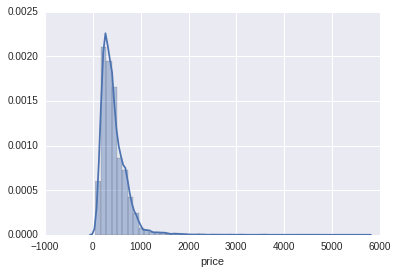

In [16]:
sns.distplot(df_all.price)

The variable has a long right tail. Let's try logarithmic transformation

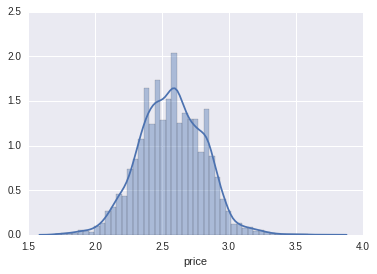

In [17]:
sns.distplot(np.log10(df_all.price))

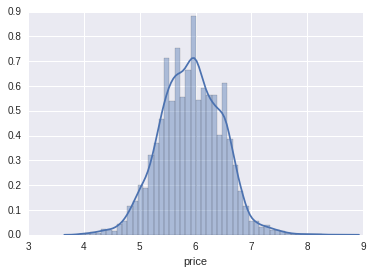

In [18]:
sns.distplot(np.log(df_all.price))

We see that the logarithmic transformation can remove the effect of the long right tail. Thus, we'll predict log of price instead of price

## Modeling

In [19]:
from sklearn.cross_validation import KFold, ShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error

import scipy.sparse as sp

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

First, we'll hold out some data for testing - it will not be used for training at all, only for final model evaluation

In [20]:
train_idx, test_idx = next(iter(ShuffleSplit(n=10000, n_iter=1, test_size=0.3, random_state=2)))

df_train = df_all.iloc[train_idx].reset_index(drop=1)
df_test = df_all.iloc[test_idx].reset_index(drop=1)

For categorical data, let's use One-Hot-Encoding

In [21]:
dv = DictVectorizer(dtype=np.uint8)
records = df_train[['loc1', 'loc2', 'loc12', 'para1', 'dow']].to_dict(orient="records")
categorical_train = dv.fit_transform(records)
categorical_train

<7000x135 sparse matrix of type '<type 'numpy.uint8'>'
	with 34447 stored elements in Compressed Sparse Row format>

We will also standardize the numerical variables to help the model converge and for easier coefficient interpretation

In [22]:
scale = StandardScaler()
num_train = df_train[['para2', 'para3', 'para2', 'para4']].values
num_train = scale.fit_transform(num_train)

In [23]:
X = sp.hstack([categorical_train, num_train], format='csr')
y = np.log10(df_train.price.values)

For evaluating the model, we'll use RMSLE (Root Mean Squared Logarithmic Error): it's about predicting the magnitude correct rather than the absolute value. The absolute error is less important when the values are quite high (and here we have some high prices). So using RMSLE is a good choice. 

For validation, we'll use 3-Fold CV:

In [24]:
cv = KFold(n=len(df_train), n_folds=3, shuffle=True, random_state=1)

RMSLE=0.145, RMSE=181.134


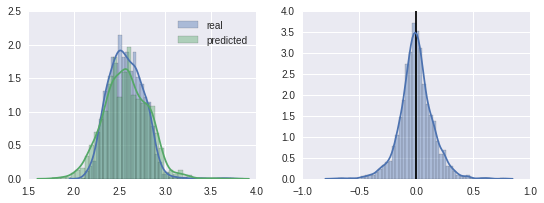

RMSLE=0.152, RMSE=184.404


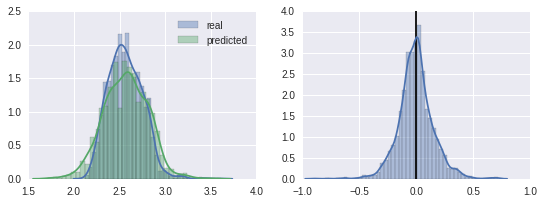

RMSLE=0.152, RMSE=353.922


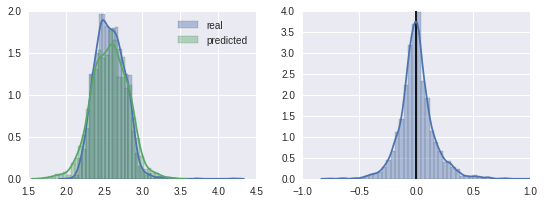

RMSLE = 0.150 ± 0.003


In [25]:
rmsles = []

for train, val in cv:
    m = LinearRegression().fit(X[train], y[train])
    y_pred = m.predict(X[val])

    rmsle = rmse(y[val], y_pred)
    rmsles.append(rmsle)

    print 'RMSLE=%.3f, RMSE=%.3f' % (rmsle, rmse(10 ** y[val], 10 ** y_pred))

    plt.figure(figsize=(9, 3))
    plt.subplot(1, 2, 1)
    sns.distplot(y_pred, hist_kws={'label': 'real'})
    sns.distplot(y[val], hist_kws={'label': 'predicted'})
    plt.legend()
    
    plt.subplot(1, 2, 2)
    sns.distplot(y_pred - y[val])
    plt.vlines(0, 0, 4)
    plt.xlim(-1, 1)
    plt.show()

print 'RMSLE = %.3f ± %0.3f' % (np.mean(rmsles), np.std(rmsles))

Now we can re-train the model on the entire training data

In [26]:
model = LinearRegression().fit(X, y)

Also, it could be interesting to look at feature importances:

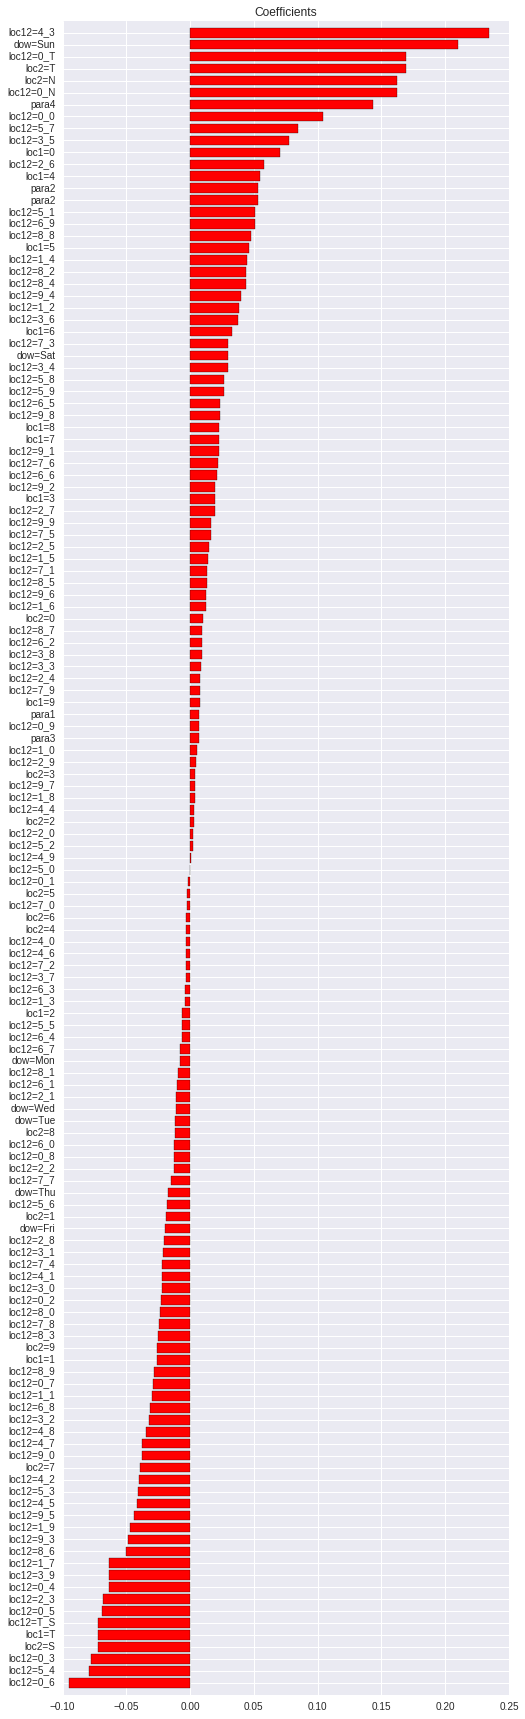

In [27]:
features = np.array(dv.feature_names_ + ['para2', 'para3', 'para2', 'para4'])
coef = model.coef_
coef_idx = np.argsort(coef)

plt.figure(figsize=(8, 30))
plt.title("Coefficients")
coef_num = range(len(coef))
plt.barh(coef_num, coef[coef_idx], color="r", align="center")

plt.yticks(coef_num, features[coef_idx])
plt.ylim([-1, X.shape[1]])

plt.show()

Variables that contribute most to high prices are `loc12=4_3` and `dow=Sun`, and to low prices: `loc12=5_4` and `loc12=0_6`

## Testing

Now let's evaluate the model on the hold-out set to make sure we don't overfit

In [28]:
records = df_test[['loc1', 'loc2', 'loc12', 'para1', 'dow']].to_dict(orient="records")
categorical_test = dv.transform(records)

In [29]:
num_test = df_test[['para2', 'para3', 'para2', 'para4']].values
num_test = scale.transform(num_test)

In [30]:
X_test = sp.hstack([categorical_test, num_test], format='csr')
y_test = np.log10(df_test.price.values)

In [31]:
y_pred = model.predict(X_test)
print rmse(y_test, y_pred)
print rmse(10 ** y_test, 10 ** y_pred)

0.150050075432
183.000854191


The RMSLE on the testing set is close to what we had on CV, so the model generalizes well

Next steps could be try a different model if the error of this one is too high. It is also possible to engineer more features, like more interactions between categorical and numerical variables.